# Download Data

## Load Datasets

In [2]:
!mkdir -p Assets

In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json


with open("Assets/converter.json", "r", encoding="utf-8") as f:
    converter = json.load(f)

label2id = {k: int(v) for k, v in converter["label2id_reduced"].items()}
id2label = {int(k): v for k, v in converter["id2label_reduced"].items()}

data = pd.read_csv('clean_data.csv', sep=';', encoding='utf-8')

# topic_id -> sequential label index
data["label"] = data["detailed_topic"].map(label2id)

# Get validation sets
_, _, _, val_labels = train_test_split(
    data["appeal"].tolist(), data["label"].tolist(), test_size=0.2, random_state=42
)

num_labels = len(label2id)
num_labels

36

## Load Stats

In [3]:
import os
import pickle

# List of expected result files
output_files = [
    "Assets/transformer_outputs.pkl",
    "Assets/classic_ml_outputs.pkl",
    "Assets/classic_ml_knn_outputs.pkl",
]

# Final merged result
combined_outputs = {}

# Loop over each expected file
for filepath in output_files:
    if os.path.exists(filepath):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
            combined_outputs.update(data)  # Merge dict contents
    else:
        print(f"File not found: {filepath}")

File not found: Assets/classic_ml_outputs.pkl
File not found: Assets/classic_ml_knn_outputs.pkl


# Per-Model Stats

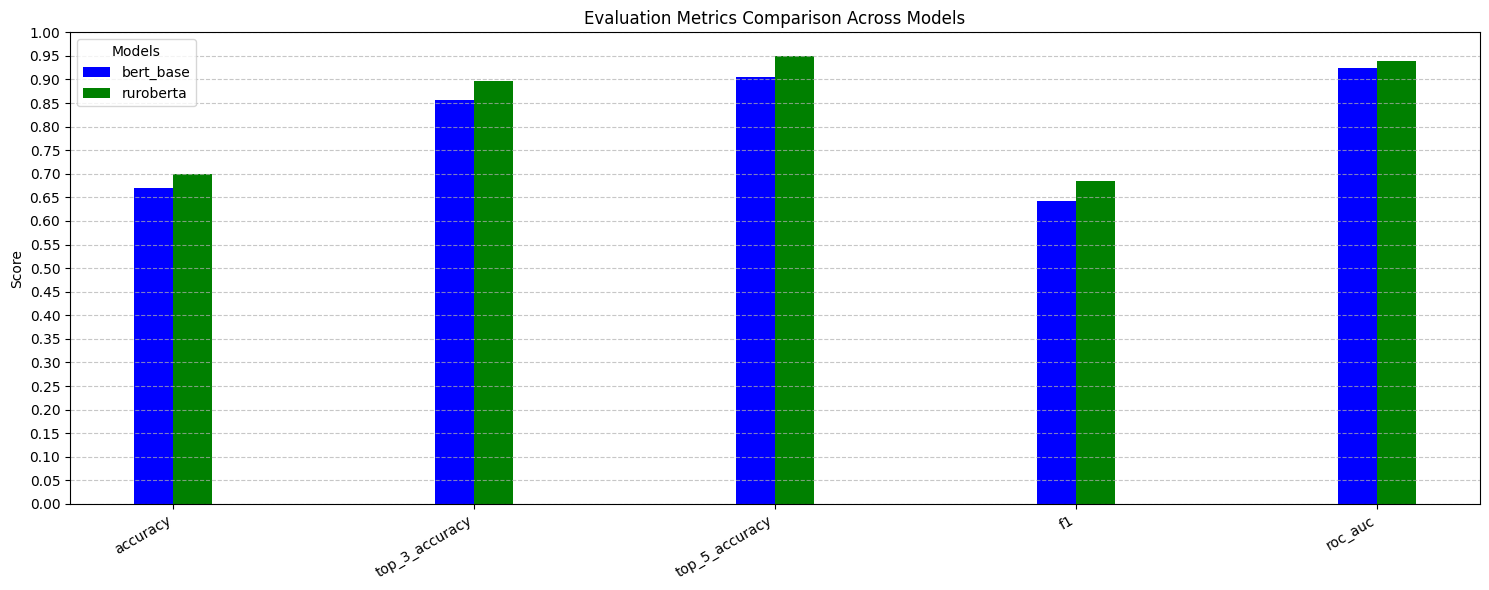

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define display names and corresponding internal keys
metric_map = {
    "accuracy": "eval_accuracy",
    "top_3_accuracy": "eval_top_3_accuracy",
    "top_5_accuracy": "eval_top_5_accuracy",
    "f1": "eval_f1",
    "roc_auc": "eval_roc_auc"
}

display_metrics = list(metric_map.keys())

# Get all model names from combined_outputs
model_names = list(combined_outputs.keys())

# Extract only the mapped metrics from each model's basic_stats
model_stats = {}
for model in model_names:
    stats = combined_outputs.get(model, {}).get("basic_stats", {})
    if isinstance(stats, dict):
        model_stats[model] = {display_name: stats.get(internal_key, 0.0)
                              for display_name, internal_key in metric_map.items()}

# Build DataFrame (rows = display metric names, columns = models)
df_stat = pd.DataFrame(model_stats).reindex(display_metrics).fillna(0.0)

# --- Plotting ---
plt.figure(figsize=(15, 6))
bar_width = 0.13
x = np.arange(len(display_metrics))

colors = ['blue', 'green', 'yellow', 'orange', 'red', 'purple', 'cyan', 'magenta']
models = df_stat.columns

for i, model in enumerate(models):
    plt.bar(x + i * bar_width, df_stat[model], width=bar_width, label=model, color=colors[i % len(colors)])

# Formatting
plt.ylabel("Score")
plt.title("Evaluation Metrics Comparison Across Models")
plt.xticks(x + bar_width * (len(models) - 1) / 2, display_metrics, rotation=30, ha='right')
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.ylim(0.0, 1)
plt.legend(title="Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


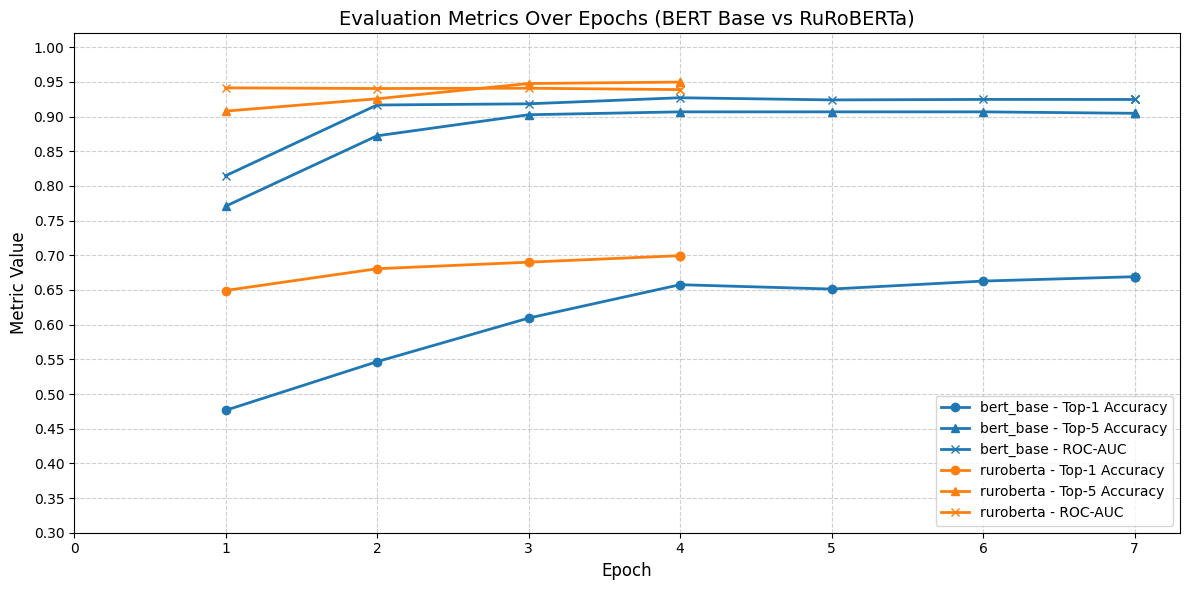

In [8]:
import numpy as np
import matplotlib.pyplot as plt

models_to_plot = ['bert_base', 'ruroberta']
metric_keys = {
    'eval_accuracy': 'Top-1 Accuracy',
    'eval_top_5_accuracy': 'Top-5 Accuracy',
    'eval_roc_auc': 'ROC-AUC'
}

colors = {
    'bert_base': 'tab:blue',
    'ruroberta': 'tab:orange'
}
markers = {
    'eval_accuracy': 'o',
    'eval_top_5_accuracy': '^',
    'eval_roc_auc': 'x'
}

plt.figure(figsize=(12, 6))

max_epoch = 0  # Track largest epoch overall

for model in models_to_plot:
    log_history = combined_outputs[model]["basic_stats"]["log_history"]

    epochs = []
    metrics_data = {k: [] for k in metric_keys}

    for log in log_history:
        if 'epoch' in log:
            epochs.append(log['epoch'])
            for k in metric_keys:
                metrics_data[k].append(log.get(k, None))

    epochs = np.array(epochs)
    if len(epochs) > 0:
        max_epoch = max(max_epoch, epochs.max())

    for metric_key, display_name in metric_keys.items():
        y_values = np.array(metrics_data[metric_key])

        valid_indices = [i for i, v in enumerate(y_values) if v is not None]
        valid_epochs = epochs[valid_indices]
        valid_values = y_values[valid_indices]

        plt.plot(
            valid_epochs,
            valid_values,
            marker=markers[metric_key],
            linestyle='-',
            linewidth=2,
            markersize=6,
            label=f"{model} - {display_name}",
            color=colors[model]
        )

plt.title("Evaluation Metrics Over Epochs (BERT Base vs RuRoBERTa)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Extend x-axis ticks to the max epoch among all models
plt.xticks(np.arange(0, max_epoch + 1, 1))
plt.yticks(np.arange(0.3, 1.05, 0.05))
plt.ylim(0.3, 1.02)

plt.tight_layout()
plt.show()


# Accuracy Comparison By Topics

In [9]:
from collections import defaultdict

def compute_class_accuracy(val_labels, predictions):
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for true_label, pred_list in zip(val_labels, predictions):
        class_total[true_label] += 1
        if true_label in pred_list:
            class_correct[true_label] += 1

    class_acc = {cls: class_correct[cls] / class_total[cls] for cls in class_total}
    sorted_acc = sorted(class_acc.items(), key=lambda x: x[1])
    return sorted_acc  # list of (class, accuracy), sorted from lowest to highest

# Dictionary to store per-model results
model_class_accuracy_stats = {}

for model_name, model_data in combined_outputs.items():
    preds = model_data.get("predictions")
    if preds is not None:
        acc_stats = compute_class_accuracy(val_labels, preds)
        model_class_accuracy_stats[model_name] = acc_stats
    else:
        print(f"Warning: No predictions found for model '{model_name}'")

# Example: print or access
for model, stats in model_class_accuracy_stats.items():
    print(f"\nModel: {model}")
    for cls, acc in stats:
        print(f"  Class {cls}: {acc:.2f}")


Model: bert_base
  Class 28: 0.00
  Class 35: 0.00
  Class 29: 0.00
  Class 30: 0.00
  Class 16: 0.00
  Class 31: 0.00
  Class 33: 0.00
  Class 32: 0.00
  Class 15: 0.08
  Class 34: 0.25
  Class 22: 0.25
  Class 19: 0.36
  Class 25: 0.50
  Class 27: 0.60
  Class 26: 0.67
  Class 24: 0.67
  Class 12: 0.76
  Class 2: 0.77
  Class 18: 0.77
  Class 11: 0.77
  Class 10: 0.79
  Class 8: 0.79
  Class 1: 0.80
  Class 14: 0.82
  Class 4: 0.87
  Class 6: 0.87
  Class 5: 0.88
  Class 21: 0.89
  Class 7: 0.93
  Class 17: 0.94
  Class 3: 0.95
  Class 13: 0.96
  Class 9: 0.97
  Class 0: 0.97
  Class 20: 1.00
  Class 23: 1.00

Model: ruroberta
  Class 35: 0.00
  Class 31: 0.00
  Class 16: 0.43
  Class 34: 0.50
  Class 32: 0.50
  Class 19: 0.55
  Class 15: 0.58
  Class 25: 0.62
  Class 26: 0.67
  Class 30: 0.67
  Class 8: 0.68
  Class 2: 0.73
  Class 11: 0.73
  Class 28: 0.75
  Class 29: 0.75
  Class 22: 0.75
  Class 1: 0.78
  Class 12: 0.80
  Class 14: 0.82
  Class 10: 0.83
  Class 24: 0.83
  Class 

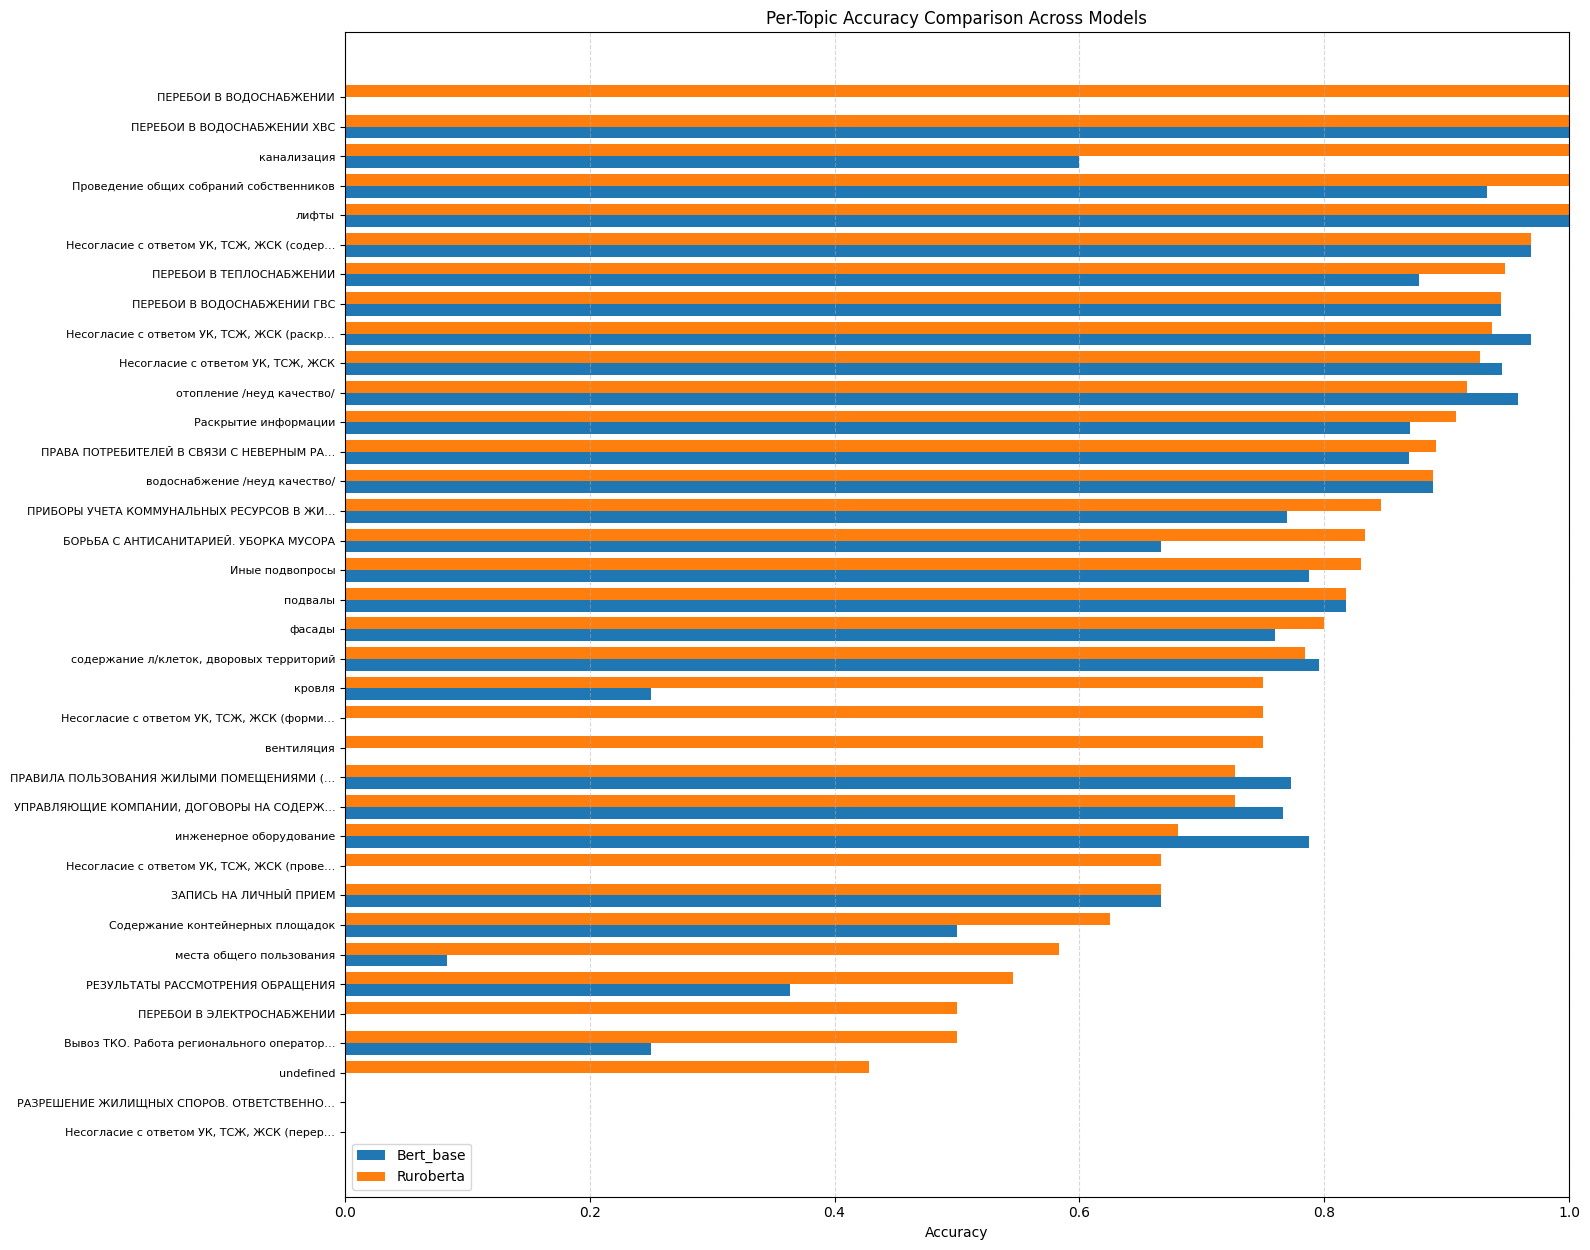

In [28]:
def get_names_dct(model_results, id2label, max_label_len=40):
    model_names = list(model_results.keys())
    n_models = len(model_names)

    # Assume all models use the same topics in the same order
    topic_ids = [tid for tid, _ in model_results[model_names[0]]]

    # Topic labels
    topic_labels = [id2label[tid][:max_label_len] + ('…' if len(id2label[tid]) > max_label_len else '')
                    for tid in topic_ids]

    return {l: model_results[model_names[0]][i][1] for i, l in enumerate(topic_labels)}


def plot_per_topic_model_comparison(model_results, id2label=None):
    """
    Plots a grouped horizontal bar chart of per-topic accuracies across multiple models.

    Args:
        model_results: Dict of {model_name: {label: accuracy}}.
        id2label: Optional dict mapping topic_id to readable label.
    """
    model_names = [k.capitalize() for k in model_results.keys()]

    # Use the first model as reference for ordering
    ref_model = 'ruroberta'
    ref_labels = list(model_results[ref_model.lower()].keys())[::-1]

    # Collect all unique labels
    all_labels = list(ref_labels)
    for model in model_names[1:]:
        for label in model_results[model.lower()]:
            if label not in all_labels:
                all_labels.append(label)  # Append new labels at the end

    all_labels = all_labels[::-1]
    # Map labels to readable names
    if id2label:
        topic_labels = [id2label.get(label, str(label)) for label in all_labels]
    else:
        topic_labels = [str(label) for label in all_labels]

    # Build data matrix with NaN for missing topics
    data_matrix = np.array([
        [model_results[model.lower()].get(label, np.nan) for label in all_labels]
        for model in model_names
    ])

    # Build DataFrame
    data = {
        model: [model_results[model.lower()].get(label, np.nan) for label in all_labels]
        for model in model_names
    }
    df = pd.DataFrame(data, index=topic_labels)

    n_models = len(model_names)
    n_topics = len(all_labels)
    bar_height = 0.8 / n_models
    y_positions = np.arange(n_topics)

    # Plotting
    fig, ax = plt.subplots(figsize=(16, n_topics * 0.35))
    colors = plt.cm.tab20.colors

    for i, model in enumerate(model_names):
        offset = (i - n_models / 2) * bar_height + bar_height / 2
        bar_pos = y_positions + offset
        ax.barh(bar_pos, data_matrix[i], height=bar_height, label=model, color=colors[(2 * i) % len(colors)])

    ax.set_yticks(y_positions)
    ax.set_yticklabels(topic_labels, fontsize=8)
    ax.set_xlabel("Accuracy")
    ax.set_title("Per-Topic Accuracy Comparison Across Models")
    ax.set_xlim(0, 1)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return df

model_stats = {}
for model_name, stats in model_class_accuracy_stats.items():
    model_stats[model_name] = get_names_dct({model_name: stats}, id2label)

res_comparison_table = plot_per_topic_model_comparison(model_stats)

In [29]:
res_comparison_table

,Bert_base,Ruroberta
"Несогласие с ответом УК, ТСЖ, ЖСК (перер…",0.000000,0.000000
РАЗРЕШЕНИЕ ЖИЛИЩНЫХ СПОРОВ. ОТВЕТСТВЕННО…,0.000000,0.000000
undefined,0.000000,0.428571
Вывоз ТКО. Работа регионального оператор…,0.250000,0.500000
ПЕРЕБОИ В ЭЛЕКТРОСНАБЖЕНИИ,0.000000,0.500000
РЕЗУЛЬТАТЫ РАССМОТРЕНИЯ ОБРАЩЕНИЯ,0.363636,0.545455
места общего пользования,0.083333,0.583333
Содержание контейнерных площадок,0.500000,0.625000
ЗАПИСЬ НА ЛИЧНЫЙ ПРИЕМ,0.666667,0.666667
"Несогласие с ответом УК, ТСЖ, ЖСК (прове…",0.000000,0.666667
